In [1]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from open_ephys.analysis import Session
import datetime
from aind_ephys_rig_qc.temporal_alignment import search_harp_line
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from utils.plot_utils import combine_pdf_big

from open_ephys.analysis import Session
from pathlib import Path
import glob

import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from aind_dynamic_foraging_basic_analysis.plot.plot_foraging_session import plot_foraging_session
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from hdmf_zarr.nwb import NWBZarrIO
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
import pandas as pd
import pickle
import scipy.stats as stats
from joblib import Parallel, delayed
from multiprocessing import Pool
from functools import partial
import time
import spikeinterface as si
import shutil
import seaborn as sns
%matplotlib inline

In [ ]:
df = pd.read_csv('/root/capsule/code/data_management/session_assets.csv')
probes = ['2.0', 'opto']
df = df[df['probe'].isin(probes)]
exclude = ['ecephys_717120_2024-03-06_12-23-53']
session_ids = df['session_id'].values
session_ids = [session for session in session_ids[:-1] if isinstance(session, str)]

In [ ]:
# load pkl data


In [60]:
# get all t-stats, coeffs, p-values for the two groups
# grab all tagged units and combine spike waveforms
data_type = 'curated'
target = 'soma'
all_coefs = []
all_T = []
all_p = []
align_name = 'response'
formula = 'spikes ~ 1 + outcome + choice + Qchosen'
curr_session = None
pre_event = -1.5
post_event = 3
model_name = 'stan_qLearning_5params'
binSize = 1.5
for session, unit_id, tag, qc in zip(all_sessions, all_units, all_tagged_units, all_qc_pass_units):
    if tag and qc: 
        curr_coefs = np.full(3, np.nan)  # initialize with NaN
        curr_T = np.full(3, np.nan)
        curr_p = np.full(3, np.nan)
        # check if different session
        if curr_session is None or curr_session != session:
            session_dir = session_dirs(session)
            unit_tbl = get_unit_tbl(session, data_type)
            session_df = makeSessionDF(session, model_name = model_name)
            curr_session = session
        unit_drift = load_drift(session, unit_id, data_type=data_type)
        spike_times = unit_tbl.query('unit_id == @unit_id')['spike_times'].values[0]
        session_df_curr = session_df.copy()
        spike_times_curr = spike_times.copy()
        # tblTrials_curr = tblTrials.copy()
        if unit_drift is not None:
            if unit_drift['ephys_cut'][0] is not None:
                spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
                session_df_curr = session_df_curr[session_df_curr['go_cue_time'] >= unit_drift['ephys_cut'][0]]
                # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] >= unit_drift['ephys_cut'][0]]
            if unit_drift['ephys_cut'][1] is not None:
                spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
                session_df_curr = session_df_curr[session_df_curr['go_cue_time'] <= unit_drift['ephys_cut'][1]]
                # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] <= unit_drift['ephys_cut'][1]]

            if align_name == 'go_cue':
                align_time = session_df_curr['go_cue_time'].values
                # align_time_all = tblTrials_curr['goCue_start_time'].values
            elif align_name == 'response':
                align_time = session_df_curr['choice_time'].values
                # align_time_all = tblTrials_curr['reward_outcome_time'].values
            # spike_matrix, slide_times = get_spike_matrix(spike_times_curr, align_time, 
            #                                             pre_event=pre_event, post_event=post_event, 
            #                                             binSize=binSize, stepSize=stepSize)
            spike_matrix_LM, slide_times_LM = get_spike_matrix(spike_times_curr, align_time, 
                                                        pre_event=pre_event, post_event=post_event, 
                                                        binSize=binSize, stepSize=0.25)
            # spike_matrix_all, slide_times = get_spike_matrix(spike_times_curr, align_time_all, 
            #                                             pre_event=pre_event, post_event=post_event, 
            #                                             binSize=binSize, stepSize=stepSize)
            spike_matrix_LM = zscore(spike_matrix_LM, axis=0)  
            try:
                regressors, curr_T, curr_p, curr_coefs = fitSpikeModelG(session_df_curr, spike_matrix_LM, formula)
            except:
                regressors, curr_T, curr_p, curr_coefs = [None]*4
        all_coefs.append(curr_coefs)
        all_T.append(curr_T)
        all_p.append(curr_p)


In [61]:
valid_shape = next((coef.shape for coef in all_coefs if coef is not None), None)
if valid_shape:
    # Replace None with a zero matrix (or another default value)
    all_coefs = [coef if coef is not None else np.full(valid_shape, np.nan) for coef in all_coefs]
    all_T = [T if T is not None else np.full(valid_shape, np.nan) for T in all_T]
    all_p = [p if p is not None else np.full(valid_shape, np.nan) for p in all_p]
all_coefsm = np.array(all_coefs)
all_Tm = np.array(all_T)
all_pm = np.array(all_p)

int_ind = (np.array(regressors) == 'Intercept') | (np.array(regressors) == 'intercept')  # find the index of the intercept
regressors = np.array(regressors)[~int_ind]  # exclude intercept from the regressors
all_coefs = all_coefsm[:, :, ~int_ind]  # exclude intercept from the coefficients
all_Tm = all_Tm[:, :, ~int_ind]  # exclude intercept from the T-statistics
all_pm = all_pm[:, :, ~int_ind]  # exclude intercept from the p-values

Text(0.5, 0.98, 'T-statistics for all regressors')

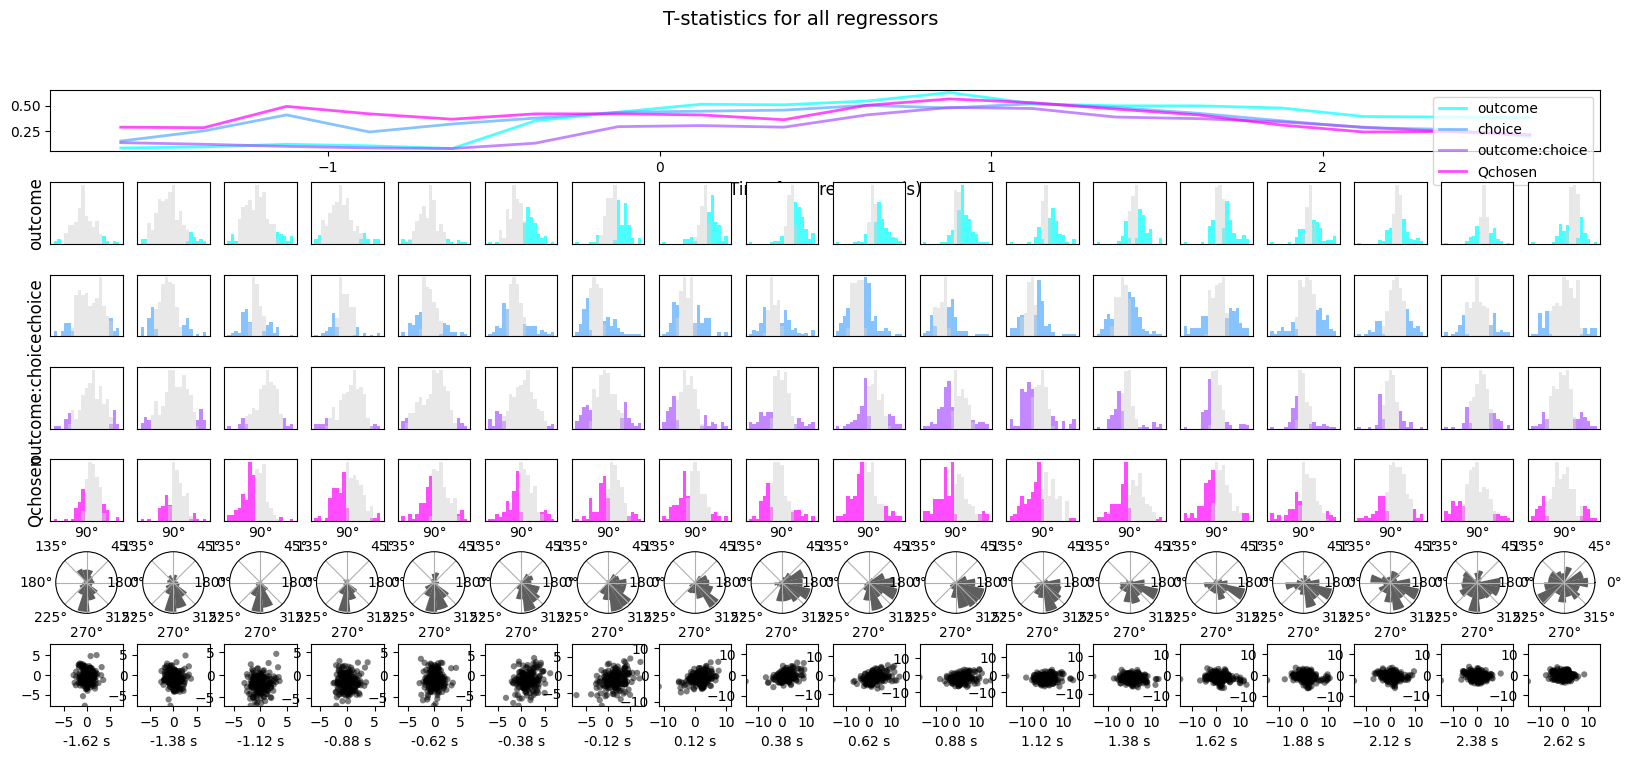

In [59]:
fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(len(regressors)+3, len(slide_times_LM), figure=fig, hspace=0.5)
cmap = plt.cm.cool  # Get the colormap
colors = cmap(np.linspace(0, 1, len(regressors)))
ax_all = fig.add_subplot(gs[0, :]) 
for reg_ind, regressor in enumerate(regressors):
    for time_ind, time in enumerate(slide_times_LM):
        ax = fig.add_subplot(gs[reg_ind+1, time_ind])
        curr_Ts = all_Tm[:, time_ind, reg_ind]  # get the T-statistics for the current regressor and time
        curr_Ps = all_pm[:, time_ind, reg_ind]  # get the p-values for the current regressor and time
        bins = np.linspace(np.nanmin(curr_Ts)-0.01, np.nanmax(curr_Ts)+0.01, 20)
        ax.hist(curr_Ts[curr_Ps<0.05], bins=bins, color=colors[reg_ind], alpha=0.7, edgecolor='none')  # plot T-statistics with p<0.05
        ax.hist(curr_Ts[curr_Ps>=0.05], bins=bins, color='lightgray', alpha=0.5, edgecolor='none')
        if time_ind == 0:
            ax.set_ylabel(f'{regressor}', fontsize=12)
        # turn off y-ticks and x-ticks
        ax.set_yticks([])
        ax.set_xticks([])

    curr_Ps = np.squeeze(all_pm[:, :, reg_ind])
    # check if any p-values are below 0.05
    curr_Ps_sig = np.nanmean(curr_Ps < 0.05, axis = 0)    
    ax_all.plot(slide_times_LM, curr_Ps_sig, color=colors[reg_ind], alpha=0.7, linewidth=2, label=regressor)  # plot the proportion of significant p-values over time
    ax_all.legend(loc='upper right', fontsize=10)
    ax_all.set_xlabel(f'Time from {align_name} (s)', fontsize=12)

reward_ind = np.where(np.array(regressors) == 'outcome')[0][0]  # find the index of the reward outcome
q_ind = np.where(np.array(regressors) == 'Qchosen')[0][0]  # find the index of the Qchosen
for time_ind, time in enumerate(slide_times_LM):
    ax = fig.add_subplot(gs[-1, time_ind])
    curr_T_reward = all_Tm[:, time_ind, reward_ind]  # get the T-statistics for the reward outcome
    curr_T_q = all_Tm[:, time_ind, q_ind]  # get the T-statistics for the Qchosen
    curr_coefs_reward = all_coefs[:, time_ind, reward_ind]  # get the coefficients for the reward outcome
    curr_coefs_q = all_coefs[:, time_ind, q_ind]  # get the coefficients for the Qchosen
    ax.scatter(curr_T_reward, curr_T_q, alpha=0.5, color='k', edgecolors='none', s=20)
    ax.set_xlabel(f'{time:.2f} s')
    limit = np.max([np.nanmax(np.abs(curr_T_reward)), np.nanmax(np.abs(curr_T_q))])
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)

    # polar
    all_vec = np.column_stack((curr_coefs_reward, curr_coefs_q))  # combine the coefficients for the reward outcome and Qchosen]))

    # Convert Cartesian coordinates to polar coordinates
    theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])

    # Define histogram edges (bins) from -π to π
    edges = np.linspace(-np.pi, np.pi, 4*4)

    # Create polar histogram
    ax = fig.add_subplot(gs[-2, time_ind], polar=True)
    ax.hist(theta, bins=edges, color=[0.1, 0.1, 0.1], alpha=0.7, edgecolor='none', density=True)
    ax.set_yticks([])

plt.suptitle('T-statistics for all regressors', fontsize=14)


Text(0.5, 0.98, 'T-statistics for all regressors')

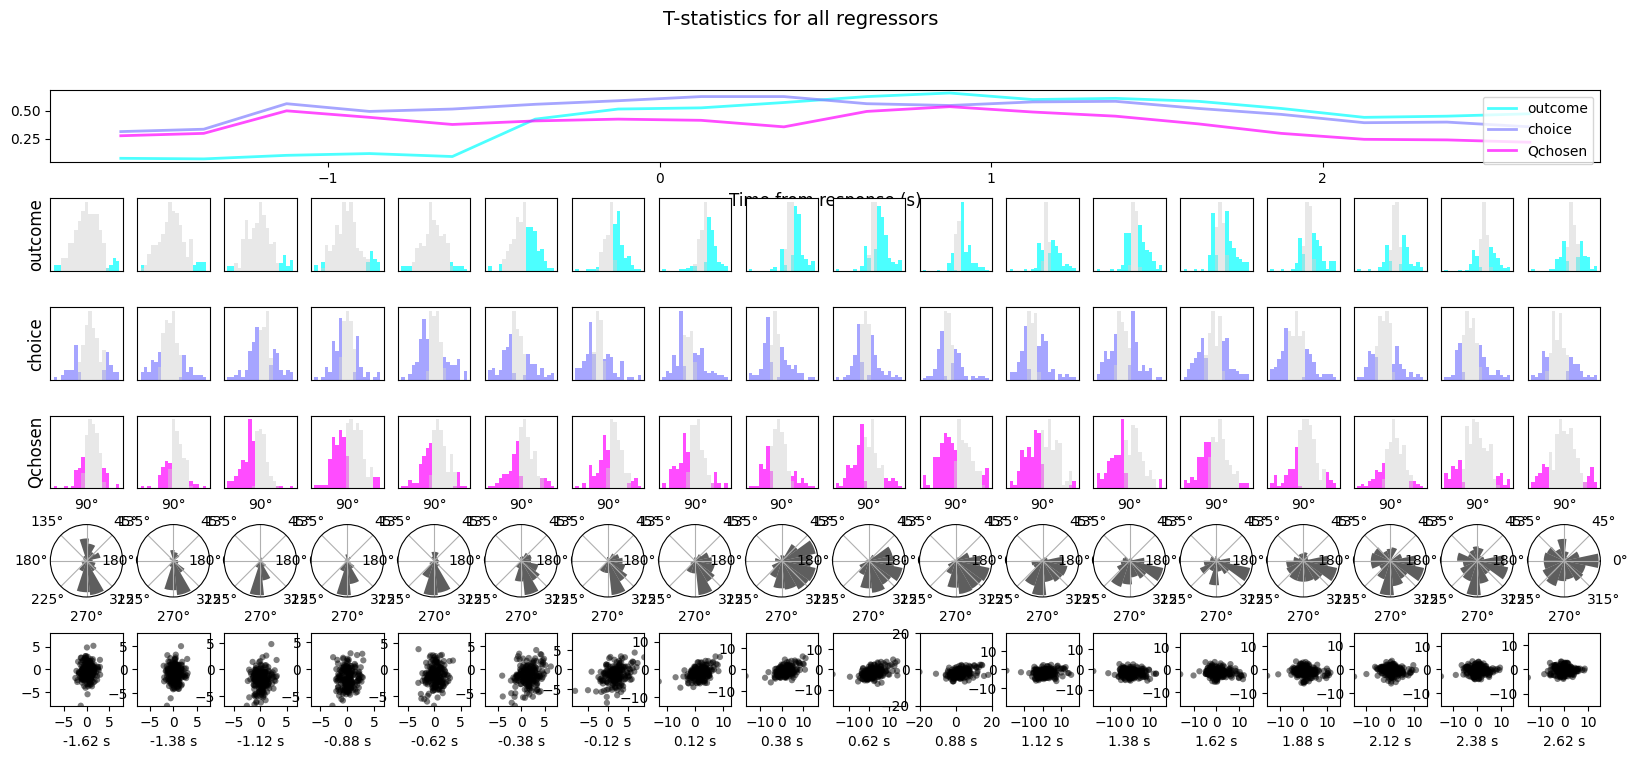

In [62]:
fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(len(regressors)+3, len(slide_times_LM), figure=fig, hspace=0.5)
cmap = plt.cm.cool  # Get the colormap
colors = cmap(np.linspace(0, 1, len(regressors)))
ax_all = fig.add_subplot(gs[0, :]) 
for reg_ind, regressor in enumerate(regressors):
    for time_ind, time in enumerate(slide_times_LM):
        ax = fig.add_subplot(gs[reg_ind+1, time_ind])
        curr_Ts = all_Tm[:, time_ind, reg_ind]  # get the T-statistics for the current regressor and time
        curr_Ps = all_pm[:, time_ind, reg_ind]  # get the p-values for the current regressor and time
        bins = np.linspace(np.nanmin(curr_Ts)-0.01, np.nanmax(curr_Ts)+0.01, 20)
        ax.hist(curr_Ts[curr_Ps<0.05], bins=bins, color=colors[reg_ind], alpha=0.7, edgecolor='none')  # plot T-statistics with p<0.05
        ax.hist(curr_Ts[curr_Ps>=0.05], bins=bins, color='lightgray', alpha=0.5, edgecolor='none')
        if time_ind == 0:
            ax.set_ylabel(f'{regressor}', fontsize=12)
        # turn off y-ticks and x-ticks
        ax.set_yticks([])
        ax.set_xticks([])

    curr_Ps = np.squeeze(all_pm[:, :, reg_ind])
    # check if any p-values are below 0.05
    curr_Ps_sig = np.nanmean(curr_Ps < 0.05, axis = 0)    
    ax_all.plot(slide_times_LM, curr_Ps_sig, color=colors[reg_ind], alpha=0.7, linewidth=2, label=regressor)  # plot the proportion of significant p-values over time
    ax_all.legend(loc='upper right', fontsize=10)
    ax_all.set_xlabel(f'Time from {align_name} (s)', fontsize=12)

reward_ind = np.where(np.array(regressors) == 'outcome')[0][0]  # find the index of the reward outcome
q_ind = np.where(np.array(regressors) == 'Qchosen')[0][0]  # find the index of the Qchosen
for time_ind, time in enumerate(slide_times_LM):
    ax = fig.add_subplot(gs[-1, time_ind])
    curr_T_reward = all_Tm[:, time_ind, reward_ind]  # get the T-statistics for the reward outcome
    curr_T_q = all_Tm[:, time_ind, q_ind]  # get the T-statistics for the Qchosen
    curr_coefs_reward = all_coefs[:, time_ind, reward_ind]  # get the coefficients for the reward outcome
    curr_coefs_q = all_coefs[:, time_ind, q_ind]  # get the coefficients for the Qchosen
    ax.scatter(curr_T_reward, curr_T_q, alpha=0.5, color='k', edgecolors='none', s=20)
    ax.set_xlabel(f'{time:.2f} s')
    limit = np.max([np.nanmax(np.abs(curr_T_reward)), np.nanmax(np.abs(curr_T_q))])
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)

    # polar
    all_vec = np.column_stack((curr_coefs_reward, curr_coefs_q))  # combine the coefficients for the reward outcome and Qchosen]))

    # Convert Cartesian coordinates to polar coordinates
    theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])

    # Define histogram edges (bins) from -π to π
    edges = np.linspace(-np.pi, np.pi, 4*4)

    # Create polar histogram
    ax = fig.add_subplot(gs[-2, time_ind], polar=True)
    ax.hist(theta, bins=edges, color=[0.1, 0.1, 0.1], alpha=0.7, edgecolor='none', density=True)
    ax.set_yticks([])

plt.suptitle('T-statistics for all regressors', fontsize=14)
